<a href="https://colab.research.google.com/github/Van-Wu1/cycle/blob/main/scr/py/normalizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/CASA0004_Cycling/data'

Mounted at /content/drive
BoroughShp  CQI  GreatLondonShp  s1  s2_Env  s3


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [ ]:
cqi = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/CQI/CQI.gpkg")
print(cqi.columns)

Index(['id', 'name', 'way_type', 'length_m', 'index_1', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'fac_5', 'LTS', 'index_2', 'fac_gvi',
       'fac_no2', 'fac_nat', 'index_3', 'edge_betweenness',
       'edge_closeness_2km', 'edge_closeness_5km', '_B_log', 'B_norm',
       'C2_norm', 'C5_norm', 'C_multi', 'cqi_index', 'cqi_index_w1',
       'cqi_index_w2', 'cqi_index_w3', 'geometry'],
      dtype='object')


In [ ]:
# 需要归一化的列
cols = ['index_1','index_2','index_3']

# Min-Max归一化到[0,100]
scaler = MinMaxScaler(feature_range=(0,100))
cqi_scaled = scaler.fit_transform(cqi[cols])

# 插入新列：放在原列前面
for i, col in enumerate(cols):
    new_col = col + "_nor"
    cqi.insert(
        cqi.columns.get_loc(col),  # 插在原字段前面
        new_col,
        cqi_scaled[:, i]
    )

# 检查结果
print(cqi[[col+"_nor" for col in cols] + cols].head())


   index_1_nor  index_2_nor  index_3_nor  index_1   index_2   index_3
0    19.387755    29.697336    13.919033     21.0  0.296973  0.083514
1    17.346939    26.220006    13.656598     19.0  0.262200  0.081940
2     7.142857    33.692822    63.820237      9.0  0.336928  0.382921
3    13.265306    51.771718     1.579539     15.0  0.517717  0.009477
4    30.612245    25.090783     3.518560     32.0  0.250908  0.021111


In [ ]:
print(cqi.columns)

Index(['id', 'name', 'way_type', 'length_m', 'index_1_nor', 'index_1',
       'base_index', 'fac_1', 'fac_2', 'fac_3', 'fac_4', 'fac_5', 'LTS',
       'index_2_nor', 'index_2', 'fac_gvi', 'fac_no2', 'fac_nat',
       'index_3_nor', 'index_3', 'edge_betweenness', 'edge_closeness_2km',
       'edge_closeness_5km', '_B_log', 'B_norm', 'C2_norm', 'C5_norm',
       'C_multi', 'cqi_index', 'cqi_index_w1', 'cqi_index_w2', 'cqi_index_w3',
       'geometry'],
      dtype='object')


In [ ]:
# === 1. 构建总的CQI指标（基础版：三个子指数的等权平均） ===
cqi['cqi_index'] = cqi[['index_1_nor', 'index_2_nor', 'index_3_nor']].mean(axis=1)

# 检查基本统计
print("CQI Index 基本统计：")
print(cqi['cqi_index'].describe())

# === 2. 为敏感性分析留出空间（例如调整权重） ===
# 定义一个函数，可以快速测试不同权重组合的结果
def calc_cqi(df, w1=1/3, w2=1/3, w3=1/3):
    """根据权重计算CQI"""
    return df['index_1_nor']*w1 + df['index_2_nor']*w2 + df['index_3_nor']*w3

# 示例：偏重 index_1
cqi['cqi_index_w1'] = calc_cqi(cqi, w1=0.5, w2=0.25, w3=0.25)

# 示例：偏重 index_2
cqi['cqi_index_w2'] = calc_cqi(cqi, w1=0.25, w2=0.5, w3=0.25)

# 示例：偏重 index_3
cqi['cqi_index_w3'] = calc_cqi(cqi, w1=0.25, w2=0.25, w3=0.5)

# 输出前几行看结果
print(cqi[['id', 'cqi_index', 'cqi_index_w1', 'cqi_index_w2', 'cqi_index_w3']].head())

CQI Index 基本统计：
count    162927.000000
mean         28.490422
std           8.378881
min           3.074518
25%          22.247515
50%          27.142806
75%          33.693479
max          72.817822
Name: cqi_index, dtype: float64
               id  cqi_index  cqi_index_w1  cqi_index_w2  cqi_index_w3
0  way/1000024348  21.001375     20.597970     23.175365     19.230790
1  way/1000024349  19.074514     18.642620     20.860887     17.720035
2  way/1000057960  34.885305     27.949693     34.587185     42.119038
3   way/100009771  22.205521     19.970467     29.597070     17.049025
4   way/100015712  19.740529     22.458458     21.078093     15.685037


描述统计：
count    162927.000000
mean         28.490422
std           8.378881
min           3.074518
25%          22.247515
50%          27.142806
75%          33.693479
max          72.817822
Name: cqi_index, dtype: float64


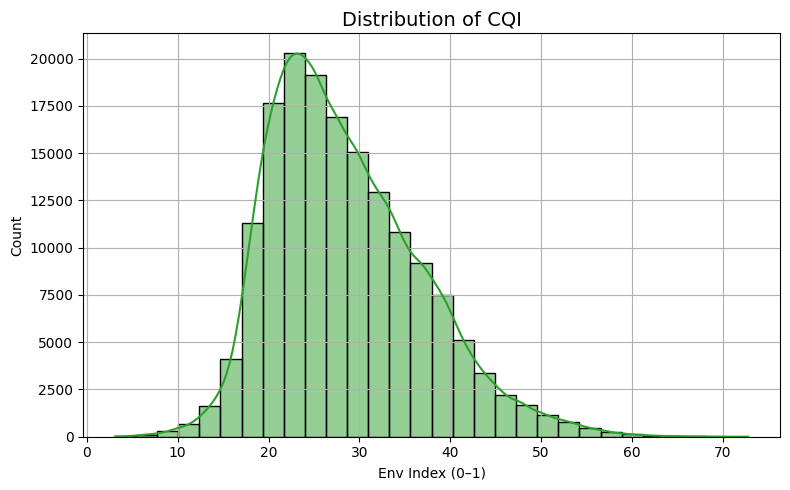

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. 描述性统计 ===
print("描述统计：")
print(cqi['cqi_index'].describe())

# === 2. 分布直方图 ===
plt.figure(figsize=(8, 5))
sns.histplot(cqi['cqi_index'], bins=30, kde=True, color="#2ca02c")
plt.title("Distribution of CQI", fontsize=14)
plt.xlabel("Env Index (0–1)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
cqi.to_file("/content/drive/MyDrive/CASA0004_Cycling/data/CQI/CQI_nor.gpkg", driver="GPKG")

print("导出成功")

导出成功
